# Composite Networks

*State of the Interactomes: an evaluation of molecular networks for generating biological insights.* Wright, SN et al. [https://doi.org/10.1101/2024.04.26.587073]  
This notebook contains code and results related to:
* Figure 4B-D

**Note: due to the size of network data sets utilized in this study, this notebook draws on summarized results rather than re-evaluating all networks directly.**

## Setup

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from neteval.network_statistics import NetworkStats, load_network_names
from neteval.gene_set_recovery_results import *
from neteval.network_constructor import *

In [2]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25

In [3]:
gitdir = os.path.expanduser('~/Git/Network_Evaluation_Tools/')
figdir = os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Figures/')
evaldir = os.path.join(gitdir, 'Data/example_outputs/')
datadir = os.path.join(gitdir, 'Data/')
network_names = load_network_names(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/network_names_final.txt'))
genesets = [ 'gwas', 'disgen', 'gwas_230727', 'exp_genesets']
geneset_names = {'gwas' : 'Genetic', 
                'disgen':'Literature',
                'gwas_230727':'Genetic 2023+',
                'exp_genesets':'Experimental'}

## Example Analysis

Composites formed from DIP, PID2 and Wan only. 

In [22]:
example_pref_file = os.path.join(gitdir, "Data/example_prefix_file.txt")

In [23]:
node_f, edge_f, nets = get_node_edge_files(evaldir, example_pref_file)

### Create Global Composites

Parameters:
* `k` is the number of networks an edge must be in to be included in the composite

In [25]:
n_dict, e_dict, data_dict = get_unique_nodes_edges(node_f, edge_f, node_pref='Entrez_')
for k in [1,2,3]:
    create_network_subset(e_dict, data_dict, os.path.join(evaldir, 'Composites'), min_dbs=k, node_pref='Entrez_', name='Global')

dip
dip finished.
pid2
pid2 finished.
wan
wan finished.
Creating network subset: 1
Creating network subset: 2
Creating network subset: 3


### Create Ranked Composites

Parameters:
* `k` - The number of top ranked networks considered
* `m` - The minimum number of supporting networks for an edge to be in the composite network

Rankings of networks are determined by the prefix file. Therefore, the prefix file should be sorted based on performance rank before creating ranked prefixes. 

In [26]:
rank_order = ['dip', 'wan', 'pid1']

In [55]:
k_list=[1,2,3]
m_list=[1,2,3]


for m in m_list:
    n_dict = defaultdict(int)
    e_dict = defaultdict(int)
    data_dict = defaultdict(list)
    n_dict, e_dict, data_dict = get_unique_nodes_edges({net:node_f[net] for net in nets[:(m-1)]}, {net:edge_f[net] for net in nets[:(m-1)]}, node_pref='Entrez_')
    for k in k_list:
        if k < m:
            pass
        else:
            n_dict, e_dict, data_dict = parse_file_network(node_f[nets[k-1]], edge_f[nets[k-1]], n_dict, e_dict, data_dict, nets[k-1], 'Entrez_')
            create_network_subset(e_dict, data_dict, os.path.join(evaldir, 'Composites'), min_dbs=m, node_pref='Entrez', name='Ranked_'+str(k))

Creating network subset: 1
Creating network subset: 1
Creating network subset: 1
dip
dip finished.
Creating network subset: 2
Creating network subset: 2
dip
dip finished.
pid2
pid2 finished.
Creating network subset: 3


### Load the composite network stats

In [73]:
composite_prefs = [f'Global_composite_min{k}' for k in [1,2,3]] + [f'Ranked_{k}_composite_min{m}' for k,m in [(1,1), (2,2), (3,3), (2,1), (3,1), (3,2)]]
with open(os.path.join(evaldir, 'composite_prefixes.txt'), 'w') as f:
    f.writelines('\n'.join(composite_prefs)+'\n')

In [74]:
example_stats = NetworkStats(os.path.join(evaldir, 'composite_prefixes.txt'), os.path.join(evaldir, 'Composites'))

In [75]:
example_df = pd.DataFrame({'Gene Count': example_stats.network_node_counts, 
                           'Interaction Count': example_stats.network_edge_counts})
example_df['prefix'] = example_df.index.values
example_df['Min Supporting networks'] = example_df.prefix.apply(lambda x: int(x.split('min')[-1]))
example_df['CompositeType'] = example_df.prefix.apply(lambda x: x.split('_composite')[0])

**Global composites**  

* Network size decreases as the number of supporting networks required increases.

<AxesSubplot:xlabel='Min Supporting networks', ylabel='Gene Count'>

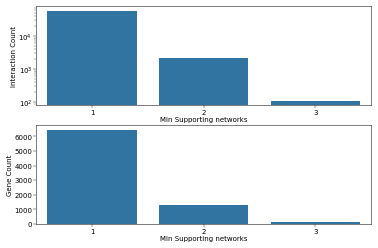

In [84]:
_, [ax1, ax2] = plt.subplots(nrows=2, ncols=1)
sns.barplot(example_df[example_df.CompositeType=='Global'], x='Min Supporting networks', y='Interaction Count', ax=ax1)
ax1.set_yscale('log')
sns.barplot(example_df[example_df.CompositeType=='Global'], x='Min Supporting networks', y='Gene Count', ax=ax2)

**Ranked Composites**  

* Network size decreases as the number of supporting networks required increases
* Network size increases as the number of top ranked networks considered increases

The network with m=1, k=1 (shown in light blue) corresponds to all interactions in the 1 top ranked network, therefore this is equivalent to the full dip network. 

Any networks that consider all 3 networks (shown in pink) are equivalent to the 'Global' composites.

<AxesSubplot:xlabel='Min Supporting networks', ylabel='Gene Count'>

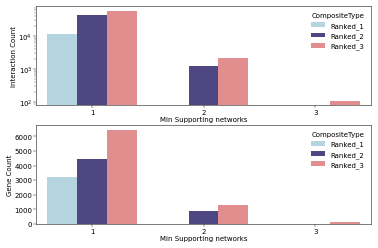

In [85]:
_, [ax1, ax2] = plt.subplots(nrows=2, ncols=1)
sns.barplot(example_df[example_df.CompositeType!='Global'], x='Min Supporting networks', y='Interaction Count', hue='CompositeType', ax=ax1, palette=['lightblue', 'darkslateblue', 'lightcoral'])
ax1.set_yscale('log')
sns.barplot(example_df[example_df.CompositeType!='Global'], x='Min Supporting networks', y='Gene Count', hue='CompositeType', palette=['lightblue', 'darkslateblue', 'lightcoral'], ax=ax2)

## Fig 4B - performance of series of global and ranked composite networks

In [8]:
# Load the precomputed results
performance_df = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/Fig4B_performance_results.csv'))

In [9]:
# Identify the constructed composites from the comparison networks
comparison_results = performance_df[performance_df['Comparator']]
performance_df = performance_df[~performance_df['Comparator']]

**Genetic and Literature Gene Set Recovery Performance**

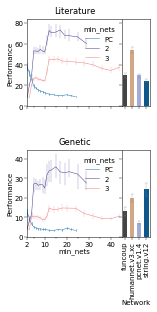

In [86]:
genesets = ['Literature', 'Genetic', 'Genetic 2023+', 'Experimental']
_, [[ax3, ax3a], [ax5, ax5a]] = plt.subplots(nrows=2, ncols=2, figsize=(2.2, 4), 
                gridspec_kw={'wspace':0, 'hspace':0.5, 'width_ratios':[1, 0.3]}, sharey='row', sharex='col')


for i, ax in enumerate([ax3, ax5]):
    # plot the comparison networks
    a = comparison_results[comparison_results['GeneSet']==genesets[i]].pivot(index='index', columns='Network', values='Performance')
    sns.barplot(a, estimator='median', ax=[ax3a, ax5a][i],errorbar=('ci', 95),err_kws={'linewidth': 0.25, 'color':'grey'}, capsize=0.4, linewidth=0.5, width=0.6, 
                palette=['#444444', '#d1a786','#a3acd8', '#0e588b'], fill=True, saturation=1)#edgecolor='k
    # Plot the Global composite networks
    sns.lineplot(data=performance_df[(performance_df.method=='PC') & (performance_df.GeneSet==genesets[i])], x='min_nets', y='Performance', hue='method',linewidth=0.5, ax=ax, err_style='bars', err_kws={'linewidth':0.5}, estimator='median')
    # Plot the ranked composite networks
    if 'OC' in performance_df.method.unique():
        sns.lineplot(data=performance_df[(performance_df.method=='OC') & (performance_df.GeneSet==genesets[i])], x='num_nets', y='Performance', hue='min_nets', ax=ax, err_style='bars', 
                    hue_order=[2,3], palette = [ 'darkslateblue', 'lightcoral'], linewidth=0.5, err_kws={'linewidth':0.25}, estimator='median')
    ax.set_title(genesets[i])
    _ = ax.set_xticks([2, 10,20,30,40])
    _ = ax.set_xticks([5, 15,25,35], minor=True)
    ax.set_xlim(2, 45)
    
    [ax3a, ax5a][i].tick_params(axis='x', rotation=90)
ax3.set_xlabel('')
ax3a.set_xlabel('')
plt.savefig(figdir+'4B_composite_performance_1.jpg', dpi=300, bbox_inches='tight')

**Genetic 2023+ and Experimental Gene Set Recovery Performance**

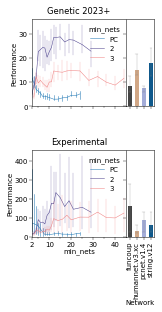

In [87]:
genesets = ['Literature', 'Genetic', 'Genetic 2023+', 'Experimental']
_, [[ax3, ax3a], [ax5, ax5a]] = plt.subplots(nrows=2, ncols=2, figsize=(2.2, 4), 
                gridspec_kw={'wspace':0, 'hspace':0.5, 'width_ratios':[1, 0.3]}, sharey='row', sharex='col')


for j, ax in enumerate([ax3, ax5]):
    i=j+2
    # Plot the comparison networks
    a = comparison_results[comparison_results['GeneSet']==genesets[i]].pivot(index='index', columns='Network', values='Performance')
    sns.barplot(a, estimator='median', ax=[ax3a, ax5a][j],errorbar=('ci', 95),err_kws={'linewidth': 0.25, 'color':'grey'}, capsize=0.4, linewidth=0.5, width=0.6, 
                palette=['#444444', '#d1a786','#a3acd8', '#0e588b'], fill=True, saturation=1)#edgecolor='k
    # Plot the 'Global' composites
    sns.lineplot(data=performance_df[(performance_df.method=='PC') & (performance_df.GeneSet==genesets[i])], x='min_nets', y='Performance', hue='method',linewidth=0.5, ax=ax, err_style='bars', err_kws={'linewidth':0.5}, estimator='median')
    # Plot the 'Ranked' composites
    if 'OC' in performance_df.method.unique():
        sns.lineplot(data=performance_df[(performance_df.method=='OC') & (performance_df.GeneSet==genesets[i])], x='num_nets', y='Performance', hue='min_nets', ax=ax, err_style='bars', 
                    hue_order=[2,3], palette = [ 'darkslateblue', 'lightcoral'], linewidth=0.5, err_kws={'linewidth':0.25}, estimator='median')
    ax.set_title(genesets[i].split('_a64_')[0])
    _ = ax.set_xticks([2, 10,20,30,40])
    _ = ax.set_xticks([5, 15,25,35], minor=True)
    ax.set_xlim(2, 45)
    
    [ax3a, ax5a][j].tick_params(axis='x', rotation=90)
ax3.set_xlabel('')
ax3a.set_xlabel('')
plt.savefig(figdir+'4B_composite_performance_2.jpg', dpi=300, bbox_inches='tight')

## Fig 4C - Performance of citation free ranked composite networks

In [88]:
nocite_df = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/Fig4C_performance_results.csv'))

In [89]:
nc_comparison_results = nocite_df[nocite_df['Comparator']]
nc_performance_df = nocite_df[~nocite_df['Comparator']]

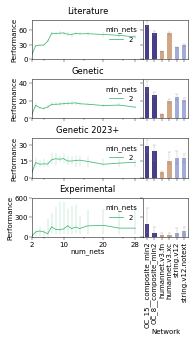

In [90]:
_, [[ax1, ax2], [ax3, ax4], [ax5, ax6], [ax7, ax8]] = plt.subplots(nrows=4, ncols=2, figsize=(2.8,4),
                                        gridspec_kw={'wspace':0, 'hspace':0.5, 'width_ratios':[1, 0.4]}, sharey='row', sharex='col')
for j, ax in enumerate([ax1, ax3, ax5, ax7]):
    i=j
    # Plot the comparison networks
    a = nc_comparison_results[nc_comparison_results['GeneSet']==genesets[i]].pivot(index='index', columns='Network', values='Performance')
    sns.barplot(a, estimator='median', ax=[ax2,ax4, ax6, ax8][j],errorbar=('ci', 95),err_kws={'linewidth': 0.25, 'color':'grey'}, capsize=0.4,  linewidth=0.25, width=0.6, 
                    palette=['darkslateblue', 'darkslateblue','#d1a786', '#d1a786','#a3acd8', '#a3acd8'], fill=True, saturation=1)
    
    gs = genesets[i]
    #Plot the 'Ranked' composite networks
    sns.lineplot(data=nc_performance_df[nc_performance_df.GeneSet==gs], x='num_nets', y='Performance', hue='min_nets', ax=ax, err_style='bars', 
            hue_order=[2], palette = [ 'mediumseagreen'], linewidth=0.75, err_kws={'linewidth':0.25}, estimator='median')
    ax.set_title(gs.split('_a64_')[0])
    [ax2, ax4, ax6, ax8][j].tick_params(axis='x', rotation=90)
    ax.set_title(gs.split('_a64_')[0])
    _ = ax.set_xticks([2, 10,20,28])
    _ = ax.set_xticks([5, 15,25,28], minor=True)
    ax.set_xlim(2, 30)

ax1.set_yticks([0,30,60])
ax3.set_yticks([0,20,40])
ax5.set_yticks([0,15,30])
ax7.set_yticks([0,300,600])

plt.savefig(figdir+'4C_citation_free_performance.jpg', dpi=300, bbox_inches='tight')

## Fig 4D - Sizes of composite networks

In [15]:
sizes_df = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/Fig4D_network_sizes.csv'), index_col=0)
sizes_df['Network'] = sizes_df.index

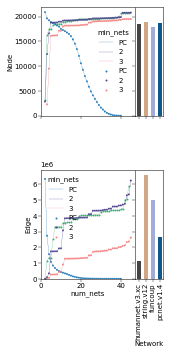

In [91]:
_, [[ ax2, ax2a], [ax4, ax4a]] = plt.subplots(nrows=2, ncols=2,figsize=(2.2, 5), 
        gridspec_kw={'wspace':0, 'hspace':0.5, 'width_ratios':[1, 0.3]}, sharey='row', sharex='col')

for i, metric in enumerate(['Node', 'Edge']):
    # Plot the lines
    sns.lineplot(data=sizes_df[(sizes_df.method=='OC') & (sizes_df.min_nets==2) & (sizes_df.Group=='NOCITE')],ax=[ax2, ax4][i], y=metric, x='num_nets', linewidth=0.25, color='mediumseagreen')
    sns.lineplot(data =sizes_df[(sizes_df.method=='PC')& (sizes_df.Group=='ALL')], x='min_nets', y=metric, hue='method', ax=[ax2, ax4][i] , linewidth=0.25)
    sns.lineplot(data =sizes_df[(sizes_df.method=='OC') & (sizes_df.min_nets>1)& (sizes_df.Group=='ALL')], x='num_nets', y=metric, hue='min_nets', ax=[ax2, ax4][i], hue_order=[2,3], 
                palette = [ 'darkslateblue', 'lightcoral'], linewidth=0.25)
    #Plot the points
    sns.scatterplot(data=sizes_df[(sizes_df.method=='OC') & (sizes_df.min_nets==2) & (sizes_df.Group=='NOCITE')],ax=[ax2, ax4][i], y=metric, x='num_nets', s=3, color='mediumseagreen', edgecolor=None)
    sns.scatterplot(data =sizes_df[(sizes_df.method=='PC')& (sizes_df.Group=='ALL')], x='min_nets', y=metric, hue='method', ax=[ax2, ax4][i], s=3, edgecolor=None)
    sns.scatterplot(data =sizes_df[(sizes_df.method=='OC') & (sizes_df.min_nets>1)& (sizes_df.Group=='ALL')], x='num_nets', y=metric, hue='min_nets', ax=[ax2, ax4][i], s=3, hue_order=[2,3], 
                palette = [ 'darkslateblue', 'lightcoral'], edgecolor=None)

    # Plot the comparison networks
    sns.barplot(sizes_df[sizes_df['Comparator']].loc[:, (metric, 'Network')], x = 'Network', y=metric, hue='Network', ax= [ax2a, ax4a][i],linewidth=0.25, width=0.6, 
                palette=['#444444', '#d1a786','#a3acd8', '#0e588b'], fill=True, saturation=1)

ax4a.tick_params(axis='x', rotation=90)
plt.savefig(figdir+'4D_network_sizes.jpg', dpi=300, bbox_inches='tight')